#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Для начала загрузим все необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

- Загрузка данных

При загрузке данных определим колонку для индексов `datetime` и произведем парсинг этой колонки по датам. Сразу отсортируем индекс по дате, поскольку далее будем решать задачу временного ряда и нам важна последовательность.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Посмотрим информацию по датасету.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В начальном датасете мы имеем из признаков только дату и время в индексе `datetime` и количество заказов `num_orders`. Данные даны с разницей в `10 минут`.

- **Ресемплирование**

Поскльку перед нами стоит задача предсказать количество заказов на час вперед, проведем ресемплирование данных с шагом в `1 час`.

In [4]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Посмотрим, как наш временной ряд выглядит на графике.

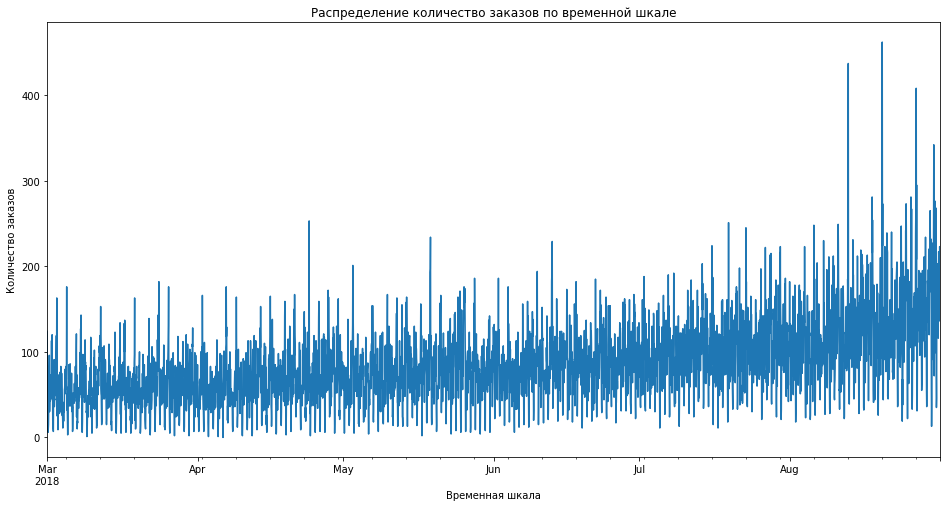

In [5]:
data['num_orders'].plot(figsize=(16, 8))
plt.title('Распределение количество заказов по временной шкале')
plt.xlabel('Временная шкала')
plt.ylabel('Количество заказов')
plt.show()

Мы видим, что под конец периода присутствует несколько всплесков - `более 300` заказов за час, в то время как даже самые большие пики находятся `с 200 до 250` заказов в час. Мы могли бы усреднить эти всплески, однако, они происходят в конце временного ряда и по расчетам должны войти в `10%` от популяции, которые по заданию станут тестовой выборкой. Мы не можем редактировать данные для теста, поэтому всплески не корректируем.

- **Добавление новых признаков**

Добавим новые признаки в популяцию:
- Календарные признаки `год`, `месяц` и `день месяца` для данной популяции большой роли не играют, поскольку вся популяция находится в рамках 6 месяцев одного года. А вот `день недели` и `час` заказа может помочь нам лучшить обучение модели.
- Отстающие значения по указанному количеству сдвигов: возьмем `3 дня`, или `72 часа`.
- Скользящее среднее и среднее стандартное отклонение со сдвигом так, чтобы целевой признак не попал в новый признак для обучения.
- Разность временного ряда, но также со сдвигом.

In [6]:
def make_features(df, max_lag, rolling_mean_size):
    df_ch = df.copy()
    
    # Добавим новые календарные признаки: год, месяц, день месяца, день недели
    df_ch['dayofweek'] = df_ch.index.dayofweek
    df_ch['hour'] = df_ch.index.hour
    
    # Добавим отстающие значения по указанному количеству сдвигов
    for lag in range(1, max_lag + 1):
        df_ch['lag_{}'.format(lag)] = df_ch['num_orders'].shift(lag)

    # Вычислим скользящее среднее и среднее стандартное отклонение
    df_ch['rolling_mean'] = df_ch['num_orders'].shift().rolling(rolling_mean_size).mean()
    df_ch['rolling_std'] = df_ch['num_orders'].shift().rolling(rolling_mean_size).std()
    
    return df_ch

max_lag = 72 # 3 дня
rolling_mean_size = 240 # 10 дней
df = make_features(data, max_lag, rolling_mean_size)
df = df.dropna()
df

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-11 00:00:00,81,6,0,73.0,80.0,62.0,54.0,33.0,102.0,60.0,...,19.0,6.0,6.0,60.0,68.0,65.0,78.0,143.0,54.633333,29.242725
2018-03-11 01:00:00,83,6,1,81.0,73.0,80.0,62.0,54.0,33.0,102.0,...,77.0,19.0,6.0,6.0,60.0,68.0,65.0,78.0,54.454167,28.946170
2018-03-11 02:00:00,36,6,2,83.0,81.0,73.0,80.0,62.0,54.0,33.0,...,97.0,77.0,19.0,6.0,6.0,60.0,68.0,65.0,54.445833,28.937626
2018-03-11 03:00:00,49,6,3,36.0,83.0,81.0,73.0,80.0,62.0,54.0,...,68.0,97.0,77.0,19.0,6.0,6.0,60.0,68.0,54.300000,28.942043
2018-03-11 04:00:00,30,6,4,49.0,36.0,83.0,81.0,73.0,80.0,62.0,...,80.0,68.0,97.0,77.0,19.0,6.0,6.0,60.0,54.229167,28.934090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,163.0,152.0,234.0,179.0,160.0,189.0,94.0,111.0,147.170833,59.733088
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,126.0,163.0,152.0,234.0,179.0,160.0,189.0,94.0,147.300000,59.675005
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,136.0,126.0,163.0,152.0,234.0,179.0,160.0,189.0,147.554167,59.572581


Мы загрузили и обработали данные, добавили дополнительные признаки, теперь мы можем преступить к анализу.

## Анализ

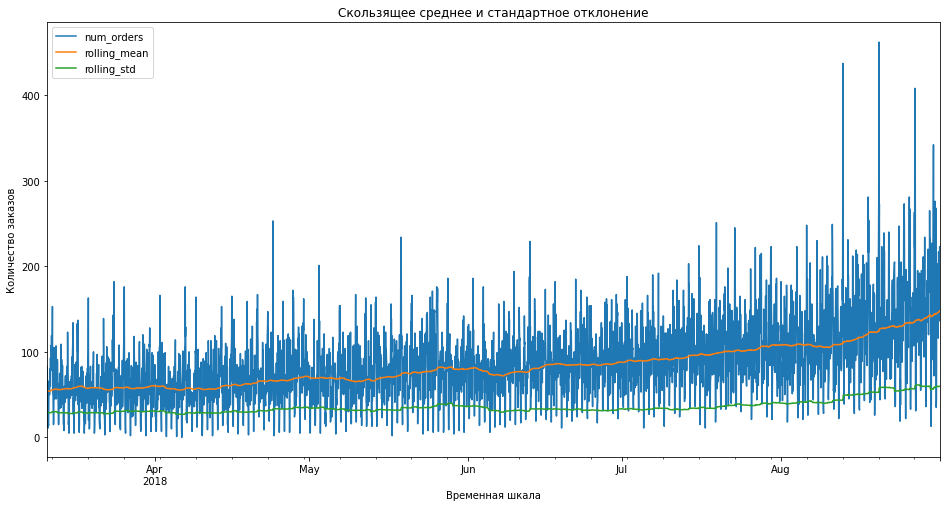

In [7]:
df.iloc[:, [0,-2,-1]].plot(figsize=(16, 8))
plt.title('Скользящее среднее и стандартное отклонение')
plt.xlabel('Временная шкала')
plt.ylabel('Количество заказов')
plt.show()

Мы видим, что среднее и стандартное отклонение несколько изменяются на протяжени времени, поэтому мы не можем назвать данный временной ряд стационарным. Нестационарные ряды прогнозировать сложнее: их свойства меняются слишком быстро.

Посмотрим на тренд и сезонность временного ряда.

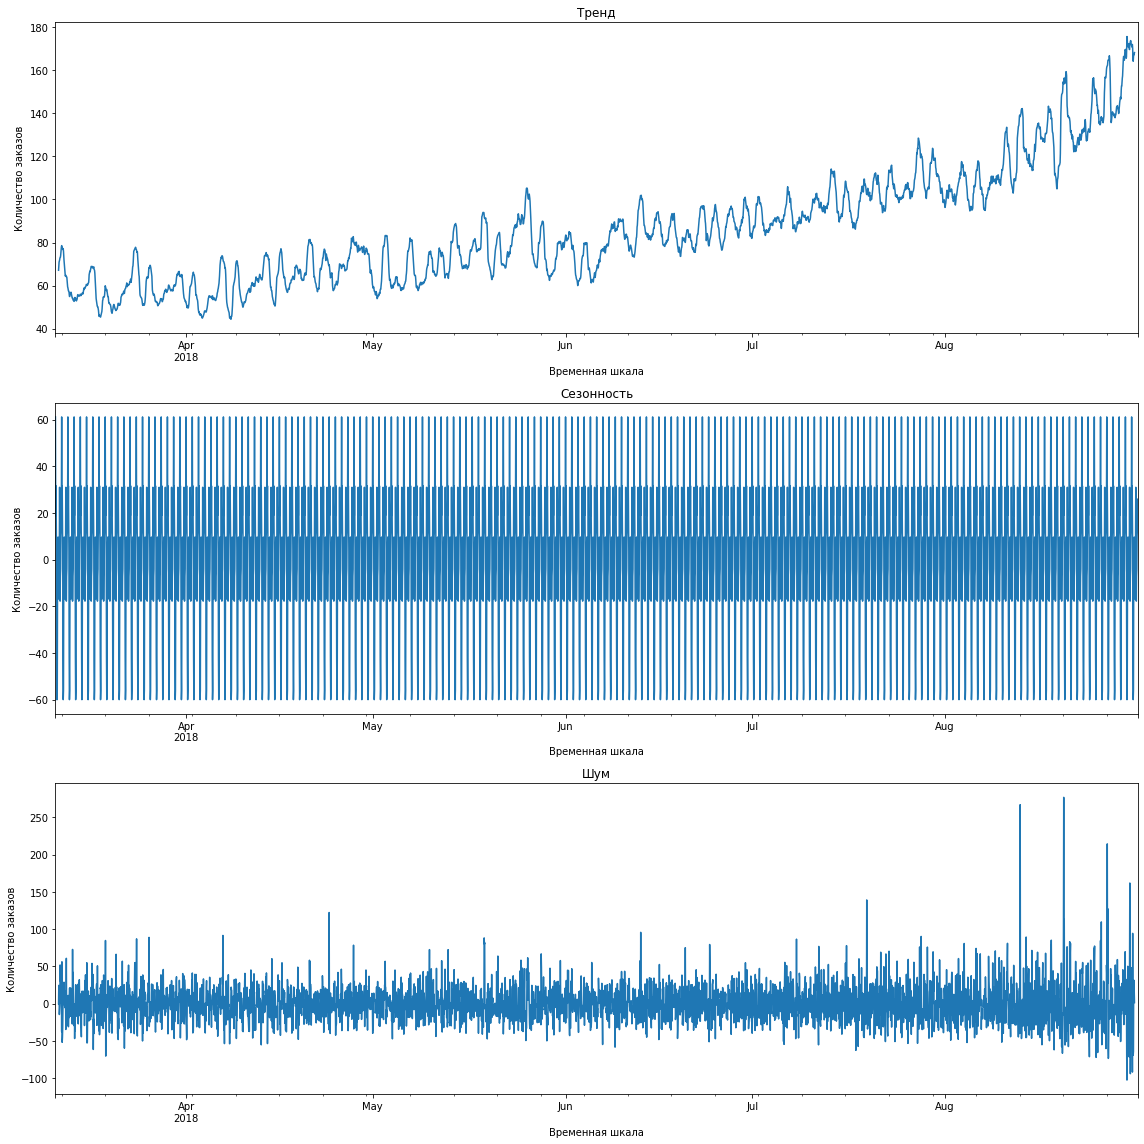

In [8]:
decomposed = seasonal_decompose(df['num_orders'])
plt.figure(figsize=(16, 16))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Временная шкала')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Временная шкала')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.xlabel('Временная шкала')
plt.ylabel('Количество заказов')
plt.tight_layout()

График тренда говорит нам о том, что количество заказов склонно увеличиваться с течением времени, т.е. количество заказов у сервиса такси планомерно растет, это может быть связано с хорошим продвижением сервиса, расширением таксопарка и т.д.

На графике с шумами мы видим, что, в целом, они равномерны. Имеются небольшие всплески без определенной периодичености. К концу временног ряда наблюдаются аномальные всплески в количестве заказов, которые достигают более `300 в час`. Поскольку для временного ряда неприемлемо перемешивание популяции при разделении выборки, а для тестовой выборки по условиям задачи необходимо взять `10%` от общей популяции, данные всплески попадают в рамки тестовой выборки. Для целей справедливой проверки качества обученной модели мы не можем корректировать данные тестовой выборки.

Поскольку сезонность трудночитаема и мы наблюдаем цикличный характер в пределах даже месяца, возьмем последний месяц, `август 2023 года`, и два последних дня, чтобы лучше рассмотреть сезонность.

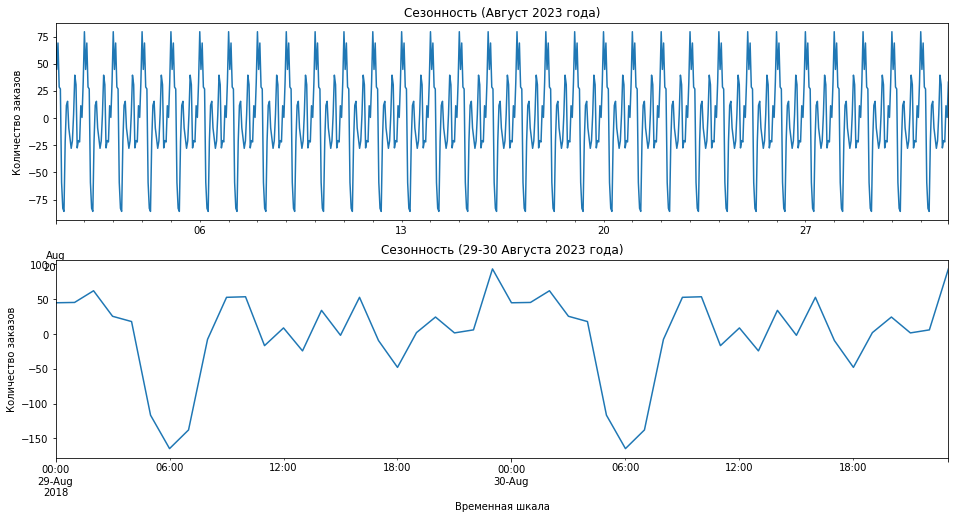

In [9]:
plt.figure(figsize=(16, 10))

plt.subplot(211)
seasonal_decompose(df['2018-08':'2018-08']['num_orders']).seasonal.plot(ax=plt.gca(), figsize=(16, 8))
plt.title('Сезонность (Август 2023 года)')
plt.xlabel('Временная шкала')
plt.ylabel('Количество заказов')
plt.subplot(212)
seasonal_decompose(df['2018-08-29':'2018-08-30']['num_orders']).seasonal.plot(ax=plt.gca(), figsize=(16, 8))
plt.title('Сезонность (29-30 Августа 2023 года)')
plt.xlabel('Временная шкала')
plt.ylabel('Количество заказов')
plt.show()

При более детальном рассмотрении мы видим, что сезонность по заказу такси вызвана временем суток и циклична по дням. Так ближе к утру количество заказов снижается, утром в час пик растет, а также растет ближе к вечеру и ночи, когда городской транспорт перестает ходить.

## Обучение

Для дальнейшего обучения моделей разделим данные на тренировочную (для обучения и кросс-валидации) и тестовую (`10%` по условию задания, для тестирования лучшей модели). В задаче временного ряда перемешивать данные нельзя, поэтому установим параметр `shuffle=False`.

In [10]:
train, test, y_train, y_test = train_test_split(df.drop(columns='num_orders'), df['num_orders'],      
                                                shuffle=False, test_size=0.1, random_state=1234)

Проведем обучение на нескольких моделях, применяя кросс-валидацию с использованием `GridSearchCV`. В параметре `scoring` для всех моделей укажем `neg_root_mean_squared_error`, чтобы оценивать модели на основе отрицательного значения среднеквадратической ошибки (`RMSE`). Использование отрицательного значения `RMSE` вместо положительного связано с тем, что `GridSearchCV` выбирает модель с наивысшим значением оценки. При использовании отрицательного значения `RMSE`, модель с меньшим значением метрики будет иметь более высокое оценочное значение.

- **Линейная регрессия**

In [11]:
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

# Инициализация модели LinearRegression
model_lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=3).split(test)

# Кросс-валидация и поиск наилучших гиперпараметров
grid_search_lr = GridSearchCV(estimator=model_lr, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search_lr.fit(train, y_train)

# Прогнозирование на тестовом наборе с использованием модели с наилучшими гиперпараметрами
best_model_lr = grid_search_lr.best_estimator_
best_params_lr = grid_search_lr.best_params_

print('Лучшие гиперпараметры:', best_params_lr)
print('Лучшее RMSE:', -round(grid_search_lr.best_score_,2))

Лучшие гиперпараметры: {'fit_intercept': False, 'normalize': True}
Лучшее RMSE: 23.9


- **Дерево решений**

In [12]:
# Определение сетки гиперпараметров для поиска
param_grid = {
    'max_depth': [1, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Инициализация модели DecisionTreeRegressor
model_dt = DecisionTreeRegressor(random_state=1234)
tscv = TimeSeriesSplit(n_splits=3).split(test)

# Кросс-валидация и поиск наилучших гиперпараметров
grid_search_dt = GridSearchCV(estimator=model_dt, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search_dt.fit(train, y_train)

# Прогнозирование на тестовом наборе с использованием модели с наилучшими гиперпараметрами
best_model_dt = grid_search_dt.best_estimator_
best_params_dt = grid_search_dt.best_params_

print('Лучшие гиперпараметры:', best_params_dt)
print('Лучшее RMSE:', -round(grid_search_dt.best_score_,2))

Лучшие гиперпараметры: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Лучшее RMSE: 24.33


- **Случайный лес**

In [13]:
# Определение сетки гиперпараметров для поиска
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [1, 5, 10, 20]
}

# Инициализация модели RandomForestRegressor
model_rf = RandomForestRegressor(random_state=1234)
tscv = TimeSeriesSplit(n_splits=3).split(test)

# Кросс-валидация и поиск наилучших гиперпараметров
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search_rf.fit(train, y_train)

# Прогнозирование на тестовом наборе с использованием модели с наилучшими гиперпараметрами
best_model_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_

print('Лучшие гиперпараметры:', best_params_rf)
print('Лучшее RMSE:', -round(grid_search_rf.best_score_,2))

Лучшие гиперпараметры: {'max_depth': 20, 'n_estimators': 30}
Лучшее RMSE: 19.59


- **XGBoost**

Также попробуем бустинговую модель `XGBoost`.

In [14]:
params = {
          'learning_rate': 0.05
         }

# Определение сетки гиперпараметров для поиска
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [5, 10, 15]
}

# Инициализация модели XGBoost
model_xgb = xgb.XGBRegressor(**params, seed=1234)
tscv = TimeSeriesSplit(n_splits=3).split(test)

# Кросс-валидация и поиск наилучших гиперпараметров
grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search_xgb.fit(train, y_train)

# Прогнозирование на тестовом наборе с использованием модели с наилучшими гиперпараметрами
best_model_xgb = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_

print('Лучшие гиперпараметры:', best_params_xgb)
print('Лучшее RMSE:', -round(grid_search_xgb.best_score_,2))

Лучшие гиперпараметры: {'max_depth': 3, 'n_estimators': 15}
Лучшее RMSE: 35.85


## Тестирование

Соберем все результаты обучения по моделям и отобразим их для удобства.

In [19]:
df_valid = pd.DataFrame({'Модель': ['Линейная регрессия', 'Дерево решений', 'Случайный лес', 'XGBoost'],
                         'RMSE тренировочной выборки': [23.9, 24.33, 19.59, 35.85]})
df_valid

,Модель,RMSE тренировочной выборки
0,Линейная регрессия,23.90
1,Дерево решений,24.33
2,Случайный лес,19.59
3,XGBoost,35.85


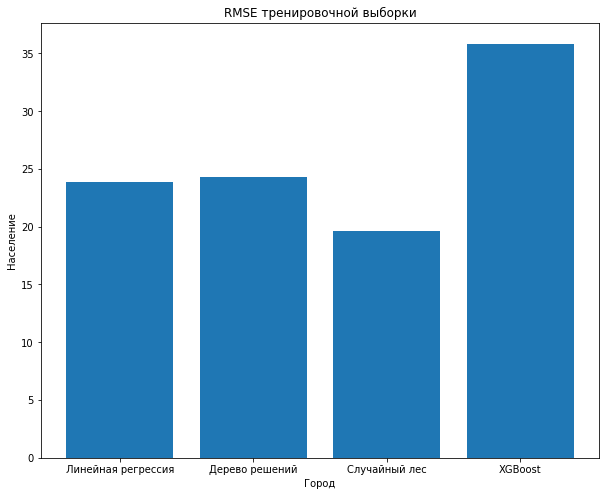

In [20]:
plt.figure(figsize=(10, 8))
plt.bar(df_valid['Модель'], df_valid['RMSE тренировочной выборки'])
plt.xlabel('Модель')
plt.ylabel('RMSE')
plt.title('RMSE тренировочной выборки')
plt.show()

В целом, можно сказать, что все модели, за исключением `XGBoost`, который показал `RMSE более 35`, справились примерно на одном уровне, разница несущественна. По условиям задачи RMSE тестовой выборки не должно превышать `48`. Все модели показали RMSE менее этого значения.

Наилучший результат показала модель `Случайный лес` с `RMSE 19.59`. Проведем тестирование на этой модели.

In [17]:
y_pred = best_model_rf.predict(test)
print("RMSE тестовой выборки:", round(mean_squared_error(y_test, y_pred, squared=False),2))

RMSE тестовой выборки: 42.81


Визуализируем временной ряд с ответами и предсказаниями для сравнения.

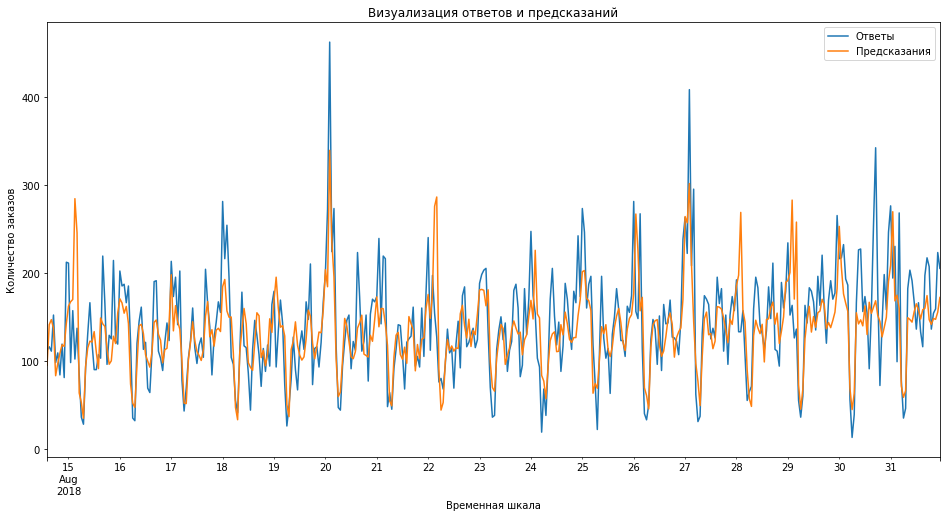

In [18]:
test_pl = y_test.copy()
test_pl = pd.DataFrame(test_pl).rename(columns={'num_orders': 'Ответы'})
test_pl['Предсказания'] = y_pred

test_pl.plot(figsize=(16, 8))
plt.xlabel('Временная шкала')
plt.ylabel('Количество заказов')
plt.title('Визуализация ответов и предсказаний')
plt.show()

По построенной визуализации ответов и предсказаний мы видим, что, в целом, наша модель повторяет значения правильных ответов. При этом на всплесках модель предсказывает более усредненные значения, что влияет на метрику качества RMSE на тесте. В целом, такой подход объясним, поскольку такие яркие всплески не наблюдаются на тренировочной выборке, а значения признаков не позволяют достаточно точно определить, чем они были вызваны, что не позволяет достаточно точно их предсказать.

Таким образом, разница между RMSE на тренировочной выборке и тестовой вызвана скорее не переобучением, а необъяснимыми всплесками в период тестовой выборки.

RMSE на тестовой выборке с использованием модели `Случайный лес` составил составил `42.81`, что укладывается в рамки поставленной задачи - `RMSE < 48`. Цель достигнута.

## Вывод
1. Мы загрузили и обработали данные с временным рядом по заказам такси.
2. Проанализировали данные и сделали соответствующие выводы, добавили дополнительные признаки для обучения.
3. Подобрали гиперпараметры и обучили четыре модели: `Линейная регрессия`, `Дерево решений`, `Случайный лес` и `XGBoost`.
4. Выбрали наилучшую по `RMSE` на тренировочной выборке модель `Случайный лес` с показателем метрики качества `19.59`.
5. Провели тестирование, метрика качества составила `42.81`, что меньше `48`, которые были установлены по условиям задачи.
6. Провели анализ результатов и сделали вывод о том, что разница между RMSE на тренировочной выборке и тестовой вызвана скорее не переобучением, а необъяснимыми всплесками в период тестовой выборки.